In [3]:
import pandas as pd
import numpy as np
import json


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
%matplotlib inline

import random
from functools import reduce
from math import sqrt,acos
from IPython.display import clear_output 
from time import sleep
import math
from scipy.stats import pearsonr,ttest_ind
import os

from lazy import Data
import helper



added DDR as DDR
added kinases as kinases
added oncs as oncs
added tsgs as tsgs
added muts as muts
added fours as fours
added CosmicCompleteGeneExpression as ge
added gene_multi_converter1 as conv
added fingerprints_19feb as fprints
added signature_descriptions as descriptions
added sig_breakdown_across_cosmic_21feb as breakdown
added gene_path as gene_path
added cosmic_mutations_and_triplets as quads
added ensgs_to_seq as ensgs_seq
added pathogenic_mutation_IDs as pathogenic_mutation_IDs
added pathogenic_quads as path_quads
added tcga_samples as tcga_samples
added TCGA_muts as TCGA_muts
added COSM_reps as COSM_reps
added TCGA_onc_muts as TCGA_onc_muts
added TCGA_tsg_muts as TCGA_tsg_muts
added sig_probs as sig_probs
added correlations as correlations
added alignments_df as alignments_df
added genes_for_consideration as genes_for_consideration
added sig_probs as sig_probs
added samples as samples
added sample_tsg_inactivated as sample_tsg_inactivated
added sample_onc_inactivated as sam

# Purpose

The notebook identifies those tsgs and oncs that are frequently
pathogenically mutated (in more than 4% of samples) and for those ones
counts the number of sites in which they are frequently mutated.
Also provides stacked bar charts of these sites and 
a heatmap of the frequency of pathogenic mutations

In [1]:
import sys
sys.path.append('../python_modules')
import misc

In [4]:
data_path = input('relative path to data ')
mutation_id = 'Mutation ID'
tsgs = Data.tsgs()
oncs = Data.oncs()

relative path to data ../Data1
loaded tsgs
loaded oncs


In [5]:
def make_pathogenic_ids():
    """Identify those mutation ids that are pathogenic
    using the assumption that only fathmm classified missense 
    mutations are GOF in oncogenes but that 
    frameshift mutations are also LOF in tumour suppressors.
    saves them.
    
    Returns list of the ids.
    """
    unique_muts = Data.muts()[[mutation_id,
                               'Mutation Description',
                               'FATHMM prediction',
                               'Gene']].drop_duplicates()

    oncs_df = pd.DataFrame(oncs,columns = ['Gene'])
    unique_oncs = pd.merge(oncs_df,unique_muts,
                           how = 'left',
                           left_on = 'Gene',
                           right_on = 'Gene'
                          )

    pathogenic = pd.DataFrame(['PATHOGENIC'],
                columns = ['FATHMM prediction'])
    unique_path_oncs = pd.merge(pathogenic,
                               unique_oncs,
                               how = 'left',
                               left_on = 'FATHMM prediction',
                               right_on = 'FATHMM prediction')

    tsg_df = pd.DataFrame(tsgs,columns = ['Gene'])
    unique_tsgs = pd.merge(tsg_df,unique_muts,
                           how = 'left',
                           left_on = 'Gene',
                           right_on = 'Gene'
                          )

    frameshift = frozenset(['Complex - frameshift',
     'Deletion - Frameshift',
     'Frameshift',
     'Insertion - Frameshift',
     'Nonstop extension',
     'Substitution - Nonsense'])

    unique_path_tsgs = unique_tsgs.loc[
        (unique_tsgs['Mutation Description'].map(
            lambda x:x in frameshift))
        |((unique_tsgs['FATHMM prediction']=='PATHOGENIC')&
        (unique_tsgs['Mutation Description']==
         'Substitution - Missense'))]
    path_list = list(set(unique_path_tsgs[mutation_id])|
        set(unique_path_oncs[mutation_id]))

    savepath = os.path.join(data_path,
            'pathogenic_mutation_IDs.json')
    with open(savepath,'w') as f:
        json.dump(path_list,f)
    return path_list

In [6]:
def get_pathogenic_ids():
    '''make_pathogenic ids if necessary 
    - otherwise just load them.
    
    Returns a list of mutation ids that are pathogenic
    using the assumption that only fathmm classified missense 
    mutations are GOF in oncogenes but that 
    frameshift mutations are also LOF in tumour suppressors.
    
    '''
    
    path_to_file = os.path.join(data_path,
        'pathogenic_mutation_IDs.json')
    if not os.path.isfile(path_to_file):
        return make_pathogenic_ids()
    else:
        with open(path_to_file) as f:
            ids = json.load(f)
        return ids

In [7]:
def get_pathogenic_muts():
    path_ids = pd.DataFrame(path_list,columns = 
                           [mutation_id])
    pathogenic_muts = pd.merge(path_ids,
                  Data.muts(),
                 how = 'left',
                 left_on = mutation_id,
                 right_on = mutation_id)

    return pathogenic_muts

In [8]:
sample_sizes = Data.muts().drop_duplicates(
    subset = 'Sample name').\
    groupby(by = 'Primary site').count()['Sample name']

/its/home/skw24/anaconda3/envs/jan/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


loaded muts


In [10]:
def get_tsg_onc_df(pathogenic_muts):
    '''create two dataframes with the percentage of 
    pathogenically mutated samples for each gene/sample
    for tsgs and oncogenes'''
    g = pathogenic_muts.groupby(by = 'Primary site').groups

    sites = sorted(list(set(pathogenic_muts['Primary site'])))

    #construct percentages of samples mutated
    tsg_percs = []
    onc_percs = []

    for site in sites:
        msite = pathogenic_muts.reindex(g[site])\
            [['Gene','Sample name']].drop_duplicates()

        genes = pd.Series(
            msite.groupby(by = 'Gene').groups).map(len)
        sample_size=len(set(msite['Sample name']))
        tsg_percs.append(100*genes.reindex(tsgs).fillna(0)/\
                         sample_size)
        onc_percs.append(100*genes.reindex(oncs).fillna(0)/\
                         sample_size)
        print(site)
        clear_output(wait = True)


    print(len(Data.tsgs()),
          len(Data.oncs()),
          len(set(Data.oncs())|set(Data.tsgs())),
          len(set(Data.oncs())&set(Data.tsgs())))

    tsg_df = pd.DataFrame(tsg_percs, index = sites)
    onc_df = pd.DataFrame(onc_percs, index = sites)
    return tsg_df,onc_df

In [14]:
def greater_than4(tsgs,oncs,tsg_df,onc_df):

    '''construct the number of tsgs,oncs,both that are frequently 
    mutated (ie >4%) in 0-15 tissue types. Plot stacked bar chart of number of genes/tissue types 
    frequently mutated and save it.
    '''


    both = set(tsgs)&set(oncs)

    just_tsgs = list(set(tsgs)-set(oncs))
    just_oncs = list(set(oncs)-set(tsgs))

    tsg_sums = tsg_df.applymap(lambda x: x>4).sum()
    onc_sums = onc_df.applymap(lambda x: x>4).sum()

    just_tsg_sums = tsg_sums.reindex(just_tsgs)
    just_onc_sums = onc_sums.reindex(just_oncs)
    both_sums = onc_sums.reindex(list(both))

    num_sites_tsgs = [just_tsg_sums[just_tsg_sums==i].shape[0]
                      for i in range(16)]
    num_sites_oncs = [just_onc_sums[just_onc_sums==i].shape[0]
                      for i in range(16)]
    num_sites_both = [both_sums[both_sums==i].shape[0]
                      for i in range(16)]
    tt_sums = pd.DataFrame([num_sites_tsgs,
                            num_sites_oncs,
                            num_sites_both]).T

    tt_sums.columns = ['tsg associated','oncogene associated',
                       'associated with tsg and onc']


    fig,ax = plt.subplots()
    tt_sums.plot(kind = 'bar',stacked = True,ax = ax)
    ax.set_xlabel('Number of tissue types')
    ax.set_ylabel('Number of driver genes')
    fig.savefig('num_genes_frequently_mutated.pdf')

In [268]:
def get_onc_percs(pathogenic_muts):
    '''for each oncogene for each site gives the 
    percentage of samples that have a pathogenic mutation 
    in the oncogene.'''
    
    pm = pathogenic_muts[['Gene','Primary site','Mutation AA']]

    df_oncs = pd.DataFrame(oncs,columns = ['Gene'])

    pm_oncs = pd.merge(df_oncs,pm,
             left_on = 'Gene',
             right_on = 'Gene',
            how = 'left')

    pm_oncs.dropna(inplace = True)
    pm_oncs['mut'] = pm_oncs['Gene']+'_'+\
        pm_oncs['Mutation AA'].map(lambda x:x[2:])

    onc_groups = pd.Series(pm_oncs.groupby(by = 'Primary site').groups)

    index = onc_groups.index
    onc_mut_vc =pd.DataFrame(list(onc_groups.map(
        lambda x: pm_oncs['mut'].reindex(x).value_counts())),
        index = index)

    onc_mut_vc.fillna(0,inplace = True)

    onc_mut_vc =onc_mut_vc.reindex(sorted(list(onc_mut_vc.index)))

    onc_mut_percs = onc_mut_vc.index.map(
        lambda x: 100*onc_mut_vc.loc[x]/sample_sizes.loc[x])

    onc_mut_percs_df = pd.DataFrame(list(onc_mut_percs))

    omp_for_plotting = onc_mut_percs_df[[i 
                    for i in onc_mut_percs_df.columns 
                      if onc_mut_percs_df[i].max()>4]].T

    ofp_index = omp_for_plotting.index.sort_values()
    return omp_for_plotting

In [18]:
def for_plotting(df):
    
    '''remove columns where the max<4 and 
    then order according to max. Returns modified
    dataframe and max'''
    t=df.max()>4
    greater_4 = t[t].index
    just_high = df[greater_4]   
    highest = just_high.max().sort_values(
        ascending = False).index
    mx = just_high.max().max()
    return df[highest].T,mx

In [20]:
def show_data(data,vmax,title,savepath):
    cmap = sns.cubehelix_palette(start=.5, rot=-.75,
                                as_cmap=True)
    cm = sns.clustermap(data, figsize = (5,40),
                        vmax = vmax,
                        vmin = 0,
                        row_cluster = False,cmap = cmap)
    cm.cax.set_visible(False)
    hm = cm.ax_heatmap.get_position()
    plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), 
             fontsize=6)
    cm.ax_heatmap.set_position([hm.x0, hm.y0, 
                hm.width, hm.height])
    col = cm.ax_col_dendrogram.get_position()
    cm.ax_col_dendrogram.set_position([col.x0, col.y0, 
                col.width, col.height*0.1])
    tl = cm.ax_heatmap.get_yticklabels()
    cm.ax_heatmap.set_yticklabels(tl, fontsize = 10);
    cm.ax_col_dendrogram.set_title(title)
    cm.fig.savefig(savepath,bbox_inches='tight')


In [ ]:
path_list= make_pathogenic_ids()
tsg_df,onc_df=get_tsg_onc_df(pathogenic_muts)
greater_than4(tsgs,oncs,tsg_df,onc_df)

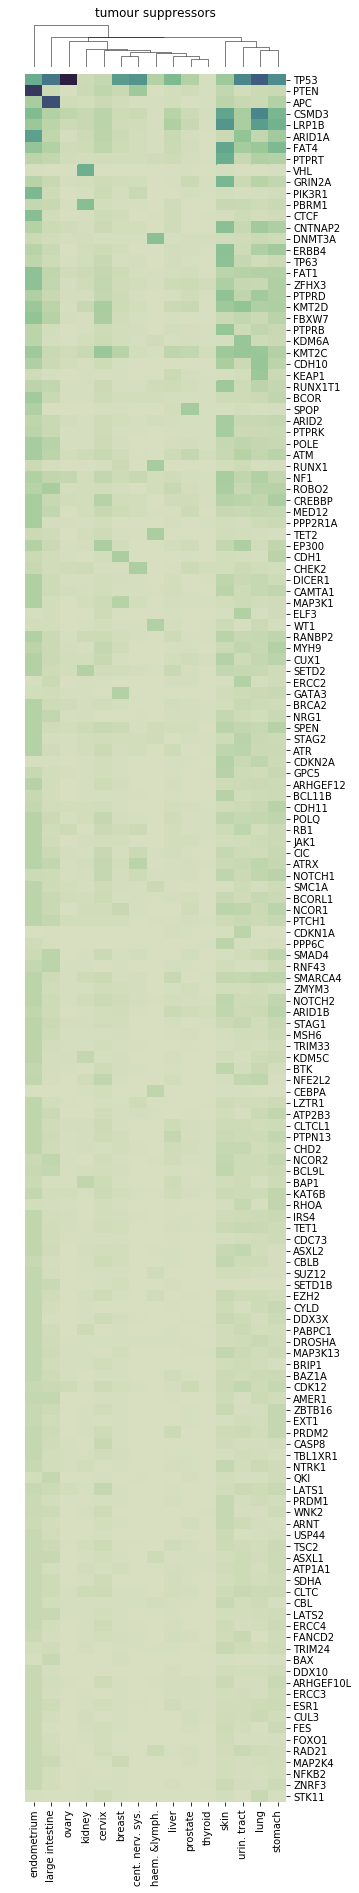

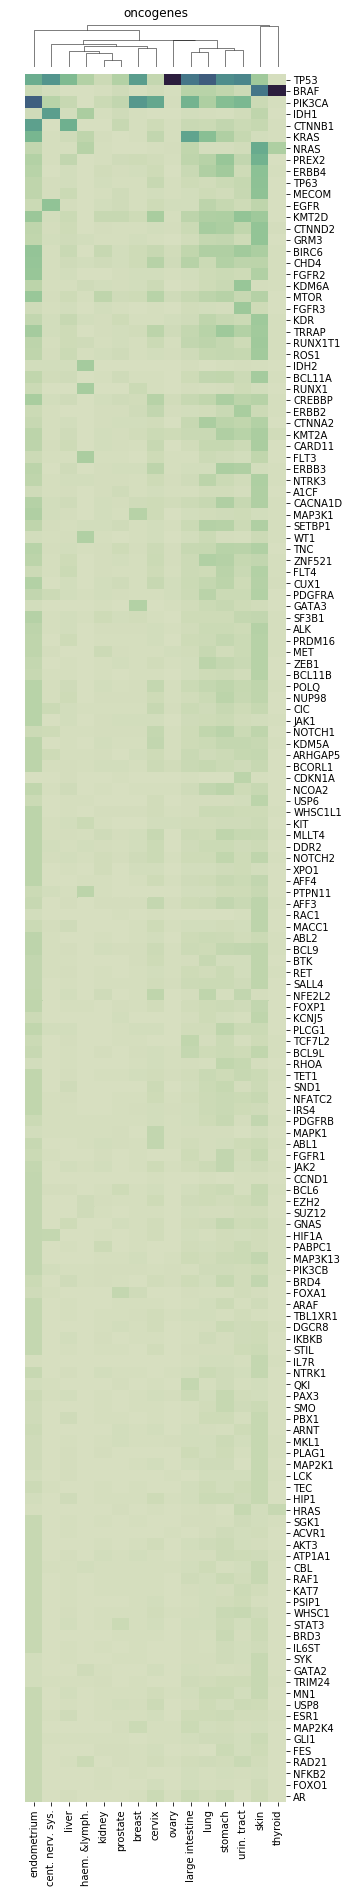

In [21]:
onc_modified,onc_mx = for_plotting(onc_df)
tsg_modified,tsg_mx = for_plotting(tsg_df)

abbrev=['breast', 
        'cent. nerv. sys.',
        'cervix', 
        'endometrium',
        'haem. &lymph.',
        'kidney', 
        'large intestine',
        'liver',
        'lung', 
        'ovary',
        'prostate', 
        'skin', 
        'stomach', 
        'thyroid',
        'urin. tract']

tsg_modified.columns = abbrev
onc_modified.columns = abbrev

vmax = max(onc_mx,tsg_mx)
vmin = 0


data = tsg_modified

show_data(tsg_modified,vmax,'tumour suppressors',
          'tsg_clustermap.pdf')
show_data(onc_modified,vmax,'oncogenes',
          'onc_clustermap.pdf')